In [0]:
!pip install -q pydicom
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q kaggle
!pip3 install -q pypng
!pip3 install -q pillow
!pip3 install PyDrive

     |████████████████████████████████| 35.1MB 89kB/s 


In [0]:
import os 
import sys
import shutil
import glob
import png
import itertools
import pydicom # for reading dicom files
#import os # for doing directory operations 
import pandas as pd # for some simple data analysis (right now, just to load in the labels data and quickly reference it)

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
import csv

Populating the interactive namespace from numpy and matplotlib


In [0]:
# enter your Kaggle credentionals here ,  you can create tokens from you profile page
os.environ['KAGGLE_USERNAME']="dhineshkumarganesan"
os.environ['KAGGLE_KEY']="505e06b2eca9ac744c6643d6e1ae5461"

In [0]:
# run from 'content' directory
# Root directory of the project
!pwd
os.mkdir('../content/RSNAdata')
ROOT_DIR = os.path.abspath('../content/RSNAdata')
os.chdir(ROOT_DIR)

/content


In [0]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=ed5d1762b44b4b8c25359dc00cb6c58c8bddd9f4a572d8e55c57cb6ecd17cc2e
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [0]:
!kaggle -v

Kaggle API 1.5.6


In [0]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge
!kaggle competitions download -c /content/RSNAdata 

100% 3.64G/3.66G [01:11<00:00, 63.5MB/s]
100% 3.66G/3.66G [01:11<00:00, 54.9MB/s]
404 - Not Found


In [0]:
# unzipping takes a few minutes
!unzip -q -o /content/RSNAdata/rsna-pneumonia-detection-challenge.zip -d /content/RSNAdata/data

In [0]:
!pwd
%cd /content/RSNAdata/data/stage_2_train_images/
!pwd
%cd /content/RSNAdata
!pwd

/content
/content/RSNAdata/data/stage_2_train_images
/content/RSNAdata/data/stage_2_train_images
/content/RSNAdata
/content/RSNAdata


In [0]:
os.chdir('../')
data_dir = '../content/RSNAdata/data/stage_2_train_images/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('../content/RSNAdata/data/stage_2_train_labels.csv')

labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
#merges the train labels and detailed class

class_info_df = pd.read_csv('../content/RSNAdata/data/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('../content/RSNAdata/data/stage_2_train_labels.csv')

train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')
#Because df3 contains doubles for every patient with two bounding boxes  
train_class_df  = train_class_df .drop_duplicates()

#This wil reset the index and drop it
train_class_df  = train_class_df.reset_index(drop=True)

train_class_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [0]:
#Changing the index here will alter the image we view.
index = 19

def parse_data(train_class_df):
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]
    #Set empty dictionary
    parsed = {}
    
    
    for n, row in train_class_df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '../content/RSNAdata/data/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'p_class': row['class'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

parsed = parse_data(train_class_df)

pat_choose = train_class_df['patientId'][index]

#This should print the file type, the file location, the label, and the location of pneumonia opacities.
print(parsed[pat_choose])

{'dicom': '../content/RSNAdata/data/stage_2_train_images/00f08de1-517e-4652-a04f-d1dc9ee48593.dcm', 'label': 1, 'p_class': 'Lung Opacity', 'boxes': [[184.0, 181.0, 506.0, 206.0], [275.0, 571.0, 476.0, 230.0]]}


In [0]:
#This will enable us to look into the data in one of our xray files

dcm_file = '../content/RSNAdata/data/stage_2_train_images/%s.dcm' % pat_choose
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1556.1517874291.545552
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00f08de1-517e-4652-a04f-d1dc9ee48593'
(0010, 0020) Patient ID                          LO: '00f08de1-517e-4652-a04f-d1dc9ee48593'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [0]:
#The following will allows for the drawing of bounding boxes on the xray images
def draw(data):
    #  Open DICOM file
    dic = pydicom.read_file(data['dicom'])
    image = dic.pixel_array

    # Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([image] * 3, axis=2)

    # Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 128).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=3)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=15):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [0]:
#This will enable us to inspect the arrays within the dicom file

im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

dcm_data.pixel_array

<class 'numpy.ndarray'>
uint8
(1024, 1024)


array([[  2,  17,  56, ...,   4,   4,   4],
       [  1,  35,  91, ...,   7,   7,   7],
       [  0,  42, 111, ...,   7,   7,   7],
       ...,
       [  0,   4,   7, ...,  15,  15,  15],
       [  0,   3,   6, ...,  11,  11,  11],
       [  0,   1,   2, ...,   0,   0,   0]], dtype=uint8)

Patient ID: 00f08de1-517e-4652-a04f-d1dc9ee48593


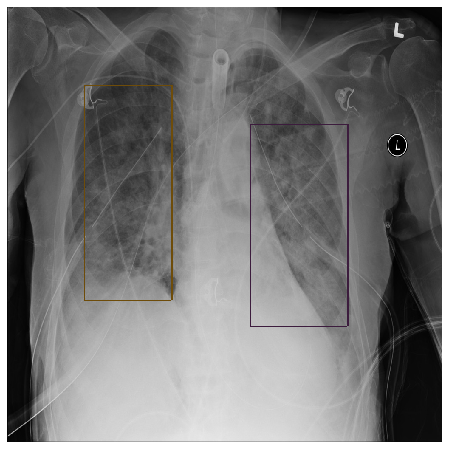

patientId    00f08de1-517e-4652-a04f-d1dc9ee48593
x                                             181
y                                             184
width                                         206
height                                        506
Target                                          1
class                                Lung Opacity
Name: 19, dtype: object


In [0]:
print("Patient ID:" + " "+ pat_choose)

pylab.figure(figsize=(10,8))
draw(parsed[pat_choose])

pylab.show()

#Viewing the data for the patient we previously selected just to double-check that our method is working
print(train_class_df.iloc[index])


Bounding Boxes of Dicom files. 
Next Perform EDA of the dataset
Setup a dataframe - Gender, Viewing Position , Age etc.

In [0]:
#Run this block to maintain consistency over later blocks of code

df_meta = train_class_df

df_meta.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [0]:
#The code below describes a method to append some of the dicom data to our pandas dataframe
##Of course, we will not be appending the pixel arrays to our dataframe


dcm_columns = None

for n, pid in enumerate(df_meta['patientId'].unique()):
    dcm_file = '../content/RSNAdata/data/stage_2_train_images/%s.dcm' % pid
    dcm_data = pydicom.read_file(dcm_file)
    
    if not dcm_columns:
        dcm_columns = dcm_data.dir()
        dcm_columns.remove('PixelSpacing')
        dcm_columns.remove('PixelData')
    
    for col in dcm_columns:
        if not (col in df_meta.columns):
            df_meta[col] = np.nan
        index = df_meta[df_meta['patientId'] == pid].index
        df_meta.loc[index, col] = dcm_data.data_element(col).value
        
    del dcm_data

In [0]:
import gc

In [0]:
gc.collect()

0

In [0]:
df_meta.head()

,patientId,x,y,width,height,Target,class,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConversionType,HighBit,InstanceNumber,LossyImageCompression,LossyImageCompressionMethod,Modality,PatientAge,PatientBirthDate,PatientID,PatientName,PatientOrientation,PatientSex,PhotometricInterpretation,PixelRepresentation,ReferringPhysicianName,Rows,SOPClassUID,SOPInstanceUID,SamplesPerPixel,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,,8.0,8.0,CHEST,1024.0,WSD,7.0,1.0,01,ISO_10918_1,CR,51,,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6,,F,MONOCHROME2,0.0,,1024.0,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.28530.15178744...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.28530.15178744...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.28530.15178744...,000000.00,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,,8.0,8.0,CHEST,1024.0,WSD,7.0,1.0,01,ISO_10918_1,CR,48,,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,,F,MONOCHROME2,0.0,,1024.0,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.26024.15178744...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.26024.15178744...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.26024.15178744...,000000.00,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,,8.0,8.0,CHEST,1024.0,WSD,7.0,1.0,01,ISO_10918_1,CR,19,,00322d4d-1c29-4943-afc9-b6754be640eb,00322d4d-1c29-4943-afc9-b6754be640eb,,M,MONOCHROME2,0.0,,1024.0,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.11252.15178743...,1.0,view: AP,1.2.276.0.7230010.3.1.3.8323329.11252.15178743...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.11252.15178743...,000000.00,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,,8.0,8.0,CHEST,1024.0,WSD,7.0,1.0,01,ISO_10918_1,CR,28,,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,,M,MONOCHROME2,0.0,,1024.0,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.2293.151787429...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.2293.151787429...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.2293.151787429...,000000.00,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,,8.0,8.0,CHEST,1024.0,WSD,7.0,1.0,01,ISO_10918_1,CR,32,,00436515-870c-4b36-a041-de91049b9ab4,00436515-870c-4b36-a041-de91049b9ab4,,F,MONOCHROME2,0.0,,1024.0,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.6379.151787432...,1.0,view: AP,1.2.276.0.7230010.3.1.3.8323329.6379.151787432...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.6379.151787432...,000000.00,AP


In [0]:
#This will identify values that are unique throughout the dataframe and defines "to_drop," 
#which will be useful for concisely determing which of the features are uniform across all patients

to_drop = df_meta.nunique()
to_drop = to_drop[(to_drop <= 1) | (to_drop == to_drop['patientId'])].index
to_drop = to_drop.drop('patientId')
to_drop

Index(['AccessionNumber', 'BitsAllocated', 'BitsStored', 'BodyPartExamined',
       'Columns', 'ConversionType', 'HighBit', 'InstanceNumber',
       'LossyImageCompression', 'LossyImageCompressionMethod', 'Modality',
       'PatientBirthDate', 'PatientID', 'PatientName', 'PatientOrientation',
       'PhotometricInterpretation', 'PixelRepresentation',
       'ReferringPhysicianName', 'Rows', 'SOPClassUID', 'SOPInstanceUID',
       'SamplesPerPixel', 'SeriesInstanceUID', 'SeriesNumber',
       'SpecificCharacterSet', 'StudyDate', 'StudyID', 'StudyInstanceUID',
       'StudyTime'],
      dtype='object')

In [0]:
#This drops the features listed in "to_drop"

df_meta.drop(to_drop, axis = 1, inplace = True)

print('Dropped {} useless features'.format(len(to_drop)))

Dropped 29 useless features


In [0]:
df_meta.head()

,patientId,x,y,width,height,Target,class,PatientAge,PatientSex,SeriesDescription,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F,view: PA,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F,view: PA,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M,view: AP,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M,view: PA,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,F,view: AP,AP


In [0]:
#The variable "SeriesDescription" 
# wasn't dropped. It will be largely unimportant in our analysis, so we can drop it, too.



#I'll remove SeriesDescription column
df_meta.drop('SeriesDescription', axis = 1, inplace = True)

#Changes patient age to integer type
df_meta['PatientAge'] = df_meta['PatientAge'].astype(int)
df_meta.head()

,patientId,x,y,width,height,Target,class,PatientAge,PatientSex,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,F,AP


In [0]:
#It's about time to rename the 'class' variable. It tends to break several python functions as it is currently named
df_meta.columns = ['patientId', 'x', 'y', 'width', 'height', 'Target', '_cla_', 'PatientAge', 'PatientSex', 'ViewPosition']

df_meta.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', '_cla_',
       'PatientAge', 'PatientSex', 'ViewPosition'],
      dtype='object')

In [0]:
#Frequency counts for sex, class, target, and viewposition

print("Class Frequency Chart"+"\n")
print(df_meta._cla_.value_counts())

print("\n"+"Sex Frequency Chart"+"\n")
print(df_meta.PatientSex.value_counts())

print("\n"+"Viewing Position Frequency Chart"+"\n")
print(df_meta.ViewPosition.value_counts())

print("\n"+"Target Frequency Chart"+"\n")
print(df_meta.Target.value_counts())

Class Frequency Chart

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: _cla_, dtype: int64

Sex Frequency Chart

M    17216
F    13011
Name: PatientSex, dtype: int64

Viewing Position Frequency Chart

AP    15297
PA    14930
Name: ViewPosition, dtype: int64

Target Frequency Chart

0    20672
1     9555
Name: Target, dtype: int64


In [0]:
#Proportions for the above variables

print("\n"+"Viewing Position Proportion"+"\n")
print(df_meta._cla_.value_counts(['']))

print("\n"+"Viewing Position Proportion"+"\n")
print(df_meta.PatientSex.value_counts(['']))

print("\n"+"Viewing Position Proportion"+"\n")
print(df_meta.ViewPosition.value_counts(['']))

print("\n"+"Viewing Position Proportion"+"\n")
print(df_meta.Target.value_counts(['']))


Viewing Position Proportion

No Lung Opacity / Not Normal    0.391074
Lung Opacity                    0.316108
Normal                          0.292818
Name: _cla_, dtype: float64

Viewing Position Proportion

M    0.569557
F    0.430443
Name: PatientSex, dtype: float64

Viewing Position Proportion

AP    0.506071
PA    0.493929
Name: ViewPosition, dtype: float64

Viewing Position Proportion

0    0.683892
1    0.316108
Name: Target, dtype: float64


<Figure size 10368x864 with 0 Axes>

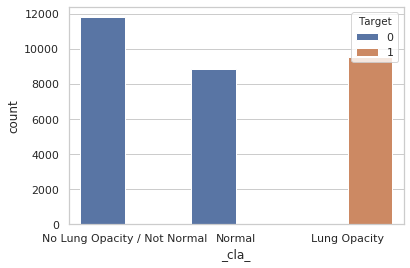

<Figure size 10368x864 with 0 Axes>

In [0]:
import seaborn as sns
sns.set(style="whitegrid")

#Countplot for the classes colored by target
sns.countplot(x = '_cla_', hue = 'Target', data = df_meta);

#You'll notice that the bars look off-center. That is because this is meant to be a clustered bar chart. However, only only target type occurs for each class variable, as expected.
plt.figure(figsize = (144, 12))

<Figure size 10368x864 with 0 Axes>

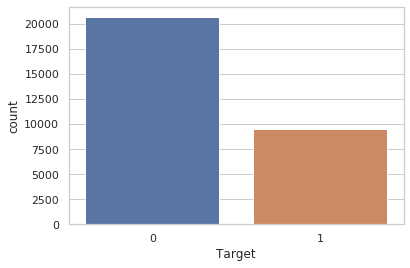

<Figure size 10368x864 with 0 Axes>

In [0]:
#Countplot for target
sns.countplot(x = 'Target', data = df_meta);

#You'll notice that the bars look off-center. That is because this is meant to be a clustered bar chart. However, only only target type occurs for each class variable, as expected.
plt.figure(figsize = (144, 12))

<Figure size 1800x360 with 0 Axes>

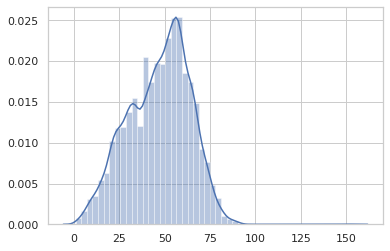

<Figure size 1800x360 with 0 Axes>

In [0]:
#Distribution plot for patient age
x = df_meta[['PatientAge']]

sns.distplot(x);


plt.figure(figsize = (25, 5))

<Figure size 1800x360 with 0 Axes>

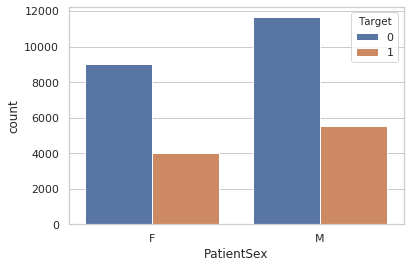

<Figure size 1800x360 with 0 Axes>

In [0]:

#Clustered column chart displaying Target frequencies among the sexes
sns.countplot(x = 'PatientSex', hue = 'Target', data = df_meta);

plt.figure(figsize = (25, 5))

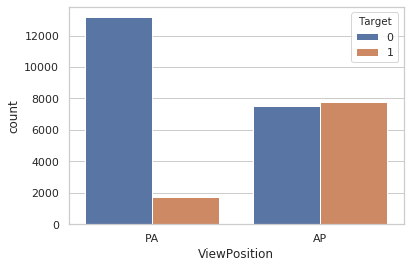

In [0]:
#Clustered column chart displaying Target frequencies among the viewing positions
sns.countplot(x = 'ViewPosition', hue = 'Target', data = df_meta);

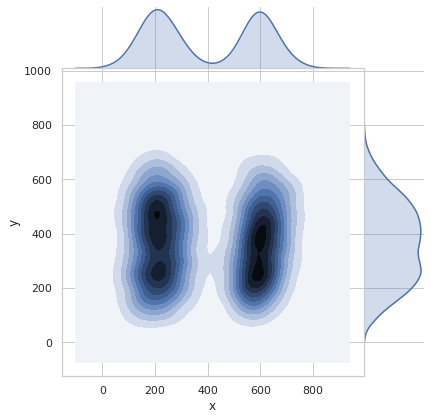

In [0]:
#Heatmap for the x and y corners of each of our bounding boxes
heat = sns.jointplot(x = 'x', y = 'y', data = df_meta, kind="kde", space=0)

#heat.ax_joint.legend_.remove()

<Figure size 432x288 with 0 Axes>

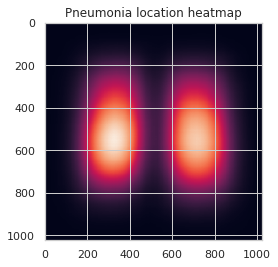

<Figure size 432x288 with 0 Axes>

In [0]:
#Importantly, the heatplot above is imperfect. The following method fills the heatmap with the area enclosed by each box.

#empty dictionary
import csv
pneumonia_locations = {}
# load table
with open(os.path.join('../content/RSNAdata/data/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()

plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()

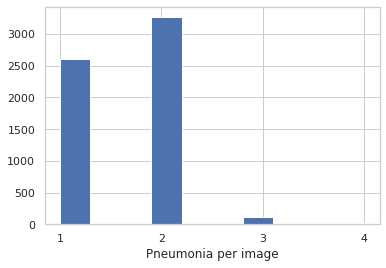

In [0]:
#This chart represents the number of pneumonia boxes present in each image
ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

In [0]:
#Explores the max and min values for the box height
print('Minimum pneumonia height:', np.min(hs))
print('Maximum pneumonia height:', np.max(hs))

#Explores the max and min values for the box width
print('Minimum pneumonia width: ', np.min(ws))
print('Maximum pneumonia width: ', np.max(ws))

Minimum pneumonia height: 45
Maximum pneumonia height: 942
Minimum pneumonia width:  40
Maximum pneumonia width:  528


## **CNN MODEL STARTS HERE**

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10280382063131762300
]


In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('../content/RSNAdata/data/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [0]:
pneumonia_locations

{'00436515-870c-4b36-a041-de91049b9ab4': [[264, 152, 213, 379],
  [562, 152, 256, 453]],
 '00704310-78a8-4b38-8475-49f4573b2dbb': [[323, 577, 160, 104],
  [695, 575, 162, 137]],
 '00aecb01-a116-45a2-956c-08d2fa55433f': [[288, 322, 94, 135],
  [547, 299, 119, 165]],
 '00c0b293-48e7-4e16-ac76-9269ba535a62': [[306, 544, 168, 244],
  [650, 511, 206, 284]],
 '00f08de1-517e-4652-a04f-d1dc9ee48593': [[181, 184, 206, 506],
  [571, 275, 230, 476]],
 '0100515c-5204-4f31-98e0-f35e4b00004a': [[703, 416, 84, 77]],
 '010ccb9f-6d46-4380-af11-84f87397a1b8': [[652, 437, 161, 293],
  [301, 405, 141, 279]],
 '012a5620-d082-4bb8-9b3b-e72d8938000c': [[133, 613, 275, 275],
  [678, 427, 224, 340]],
 '0174c4bb-28f5-41e3-a13f-a396badc18bd': [[155, 182, 273, 501],
  [599, 220, 227, 508]],
 '019d950b-dd38-4cf3-a686-527a75728be6': [[229, 318, 250, 301],
  [604, 216, 196, 328]],
 '01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce': [[141, 306, 225, 327],
  [609, 285, 236, 355]],
 '01a7353d-25bb-4ff8-916b-f50dd541dccf': [[214, 

In [0]:
# load and shuffle filenames
folder = '../content/RSNAdata/data/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
#Roughly 80:20 split
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n training samples', len(train_filenames))
print('n validation samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n training samples 24124
n validation samples 2560


# **CNN MODEL**

In [0]:
#Defining a generator allows the model to arrange processes without loading everything into memory at once.
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size))
        msk = resize(msk, (self.image_size, self.image_size)) > 0.5
        
        
        '''
        commented due to Mode parameter not exists in resize
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        msk = resize(msk, (self.image_size, self.image_size), mode='symmetric') > 0.5

        '''
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size))
        
        
        '''
        commented due to Mode parameter not exists in resize
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        '''
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
!pip uninstall keras
!pip install keras==2.2.2
#!pip install tensorflow==1.10.0
print(tf.__version__)
print(keras.__version__)

Uninstalling Keras-2.2.2:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? n
1.10.0
2.1.6-tf


In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '../content/RSNAdata/data/stage_2_train_images/'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=20, shuffle=True)

Epoch 1/20


InvalidArgumentError: ignored

In [0]:

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()